# Text mining

## Appuie pour faire tourner les fonctions

### Config

Les modules à installer se trouvent dans requirements.txt

Import and download

In [1]:
import json
import os
import re
import string
import nltk 
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ducar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ducar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ducar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ducar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Configuration

In [2]:
STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)
STOP_WORDS.update(['employee', 'organization', 'work', 'job', 'company', "'s"])
STEMMER = nltk.stem.SnowballStemmer('english')
SIA = SentimentIntensityAnalyzer()

### Fonctions utilitaires

Chargement du fichier de contenu

In [3]:
def load_data(content_path, links_path):
    if not os.path.exists(content_path):
        raise FileNotFoundError(f"Le fichier '{content_path}' est introuvable.")
    with open(content_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
    if not os.path.exists(links_path):
        raise FileNotFoundError(f"Le fichier '{links_path}' est introuvable.")
    with open(links_path, 'r', encoding='utf-8') as file:
        links = json.load(file)
    
    return content, links

Sauvegarde des données

In [4]:
os.makedirs('output', exist_ok=True)

def save_to_file(data, filename):
    if isinstance(data, np.ndarray):
        np.savetxt(f'output/{filename}.txt', data, fmt='%.4f')
    elif isinstance(data, dict):
        with open(f'output/{filename}.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    elif isinstance(data, list):
        with open(f'output/{filename}.txt', 'w', encoding='utf-8') as f:
            for line in data:
                f.write(line + '\n')


links pour chaque clusters

In [5]:
def create_links_per_cluster(clusters_dir, original_links_path, output_dir):
    # Charger les liens originaux
    with open(original_links_path, 'r', encoding='utf-8') as f:
        original_links = json.load(f)

    # Créer un répertoire pour stocker les nouveaux fichiers
    os.makedirs(output_dir, exist_ok=True)

    # Parcourir tous les fichiers de clusters dans le répertoire spécifié
    for cluster_file in os.listdir(clusters_dir):
        cluster_path = os.path.join(clusters_dir, cluster_file)

        # Charger le fichier du cluster
        with open(cluster_path, 'r', encoding='utf-8') as f:
            cluster_nodes = json.load(f)

        # Préparer un dictionnaire pour les liens de ce cluster
        cluster_links = {}

        # Parcourir les nœuds du cluster et ajouter leurs liens
        for node in cluster_nodes:
            if node in original_links:
                cluster_links[node] = [
                    target for target in original_links[node] if target in cluster_nodes
                ]

        # Nommer le fichier de sortie basé sur le fichier du cluster
        cluster_label = os.path.splitext(cluster_file)[0]
        output_path = os.path.join(output_dir, f"{cluster_label}_links.json")

        # Sauvegarder les liens filtrés dans un fichier JSON
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(cluster_links, f, ensure_ascii=False, indent=4)

        print(f"Fichier de liens créé pour le cluster : {output_path}")


JSON TO GML

In [6]:
def json_to_gml (links_path, output_file):
    with open(links_path, "r", encoding="utf-8") as file:
        links_path = json.load(file)
    nodes = set()
    edges = []
    # Parcourir les liens et extraire les nœuds et les connexions
    for source, targets in links_path.items():
        nodes.add(source)
        for target in targets:
            nodes.add(target)
            edges.append((source, target))

    # Étape 3 : Assigner des ID aux nœuds (sans utiliser enumerate)
    node_id = {}
    current_id = 0
    for node in nodes:
        node_id[node] = current_id
        current_id += 1

    # Étape 4 : Écrire le fichier GML
    with open(output_file, "w", encoding="utf-8") as file:
        file.write("graph\n")
        file.write("[\n")
        file.write("  directed 1\n")  # Graph orienté

        # Ajouter les nœuds
        for node, id in node_id.items():
            file.write("  node\n")
            file.write("  [\n")
            file.write(f"    id {id}\n")
            file.write(f"    label \"{node}\"\n")
            file.write("  ]\n")

        # Ajouter les arêtes
        for source, target in edges:
            file.write("  edge\n")
            file.write("  [\n")
            file.write(f"    source {node_id[source]}\n")
            file.write(f"    target {node_id[target]}\n")
            file.write("  ]\n")

        file.write("]\n")

    print(f"Fichier GML créé : {output_file}")

Traitement du contenu texte

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [STEMMER.stem(token) for token in tokens if token not in STOP_WORDS and len(token) > 2]
    return tokens

Sauvegarder tous les tokens

In [8]:
def clean_and_save_tokens(content, output_file):
    cleaned_data = {}

    for page_title, page_content in content.items():
        tokens = preprocess_text(page_content)
        cleaned_data[page_title] = tokens

    save_to_file(cleaned_data, output_file)

Traitement de texte spécifique à SIA, pour éviter de supprimer les "not" et autres

In [9]:
def preprocess_SIA(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

Liste des tokens

In [10]:
def tokenize_corpus(corpus):
    all_tokens = []
    for content in corpus.values():
        all_tokens.extend(preprocess_text(content))
    return all_tokens

### Différents modèles de text mining

Trouver les phrases comprenant un ou des mots

In [11]:
def find_sentences_with_words(corpus, words):
    sentences_with_words = []
    for content in corpus.values():
        sentences = sent_tokenize(content)
        for sentence in sentences:
            if all(word in sentence.lower() for word in words):
                sentences_with_words.append(sentence)
    return sentences_with_words

Analyse de sentiment

In [12]:
def analyze_word_sentiment(sentences):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = {"positive": 0, "negative": 0, "neutral": 0, "compound": 0}
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_scores["positive"] += scores["pos"]
        sentiment_scores["negative"] += scores["neg"]
        sentiment_scores["neutral"] += scores["neu"]
        sentiment_scores["compound"] += scores["compound"]

    # Moyenne des scores
    num_sentences = len(sentences)
    if num_sentences > 0:
        sentiment_scores = {key: value / num_sentences for key, value in sentiment_scores.items()}

    # Déterminer le sentiment principal
    if sentiment_scores["positive"] > sentiment_scores["negative"] and sentiment_scores["positive"] > sentiment_scores["neutral"]:
        sentiment = "Positif"
    elif sentiment_scores["negative"] > sentiment_scores["positive"] and sentiment_scores["negative"] > sentiment_scores["neutral"]:
        sentiment = "Négatif"
    else:
        sentiment = "Neutre"

    return sentiment_scores, sentiment

def word_sentiment_analysis(content, word):

    # Trouver les phrases contenant le mot
    sentences_with_word = find_sentences_with_words(content, word)
    if not sentences_with_word:
        return f"Le mot '{word}' n'apparaît pas dans le corpus."

    # Analyser le sentiment des phrases
    sentiment_scores, sentiment = analyze_word_sentiment(sentences_with_word)

    return {
        "word": word,
        "sentences_with_word": sentences_with_word,
        "sentiment_scores": sentiment_scores,
        "overall_sentiment": sentiment
    }


Bigrammes

In [13]:
def get_top_bigrams(corpus, freq_filter=5, top_n=10):
    all_tokens = tokenize_corpus(corpus)
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(all_tokens)
    finder.apply_freq_filter(freq_filter)
    return finder.nbest(bigram_measures.likelihood_ratio, top_n)

Analyse des tokens

In [14]:
def show_top_tokens(corpus, top_n=20):
    all_tokens = tokenize_corpus(corpus)
    freq_dist = nltk.FreqDist(all_tokens)
    return freq_dist.most_common(top_n)

Wordcloud

In [15]:
def generate_wordcloud(corpus, output_filename='wordcloud.png'):
    all_tokens = tokenize_corpus(corpus)
    text = ' '.join(all_tokens)
    wordcloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=30, min_font_size=10).generate(text)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'output/{output_filename}', format='png')
    plt.show()

### Clustering

Sauvegarder les datas dans des fichiers JSON

Matrice de similarité par cosinus

In [16]:

def calculate_cosine_similarity(content):
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    
    # Calcul de la matrice de similarité par le cosinus
    similarity_matrix = cosine_similarity(X_tfidf)
    save_to_file(similarity_matrix, 'similarity_matrix')
    
    return similarity_matrix

Calculer le nombre optimal de clusters 
- par la méthode du coude

In [26]:
def find_optimal_clusters(content, max_k=10):
    with open(content, encoding='utf-8') as file:
        content = json.load(file)

    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, max_iter=100, n_init=5, random_state=42)
        kmeans.fit(X_tfidf)
        distortions.append(kmeans.inertia_)
    
    # Crée le répertoire output s'il n'existe pas
    os.makedirs('output', exist_ok=True)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Nombre de Clusters')
    plt.ylabel('Distorsion')
    plt.title('Méthode du Coude')
    plt.savefig('output/elbow_method.png')
    plt.show()
    
    # Retourne le nombre optimal basé sur l'inflexion
    optimal_k = np.diff(distortions).argmin() + 2
    return optimal_k

Clusters

In [33]:
def cluster_documents(content, num_clusters):
    with open(content, encoding='utf-8') as file:
        content = json.load(file)

    documents = list(content.values())
    
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(documents)
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, n_init=10, random_state=42)
    kmeans.fit(X_tfidf)
    
    clusters = {}
    for i, doc in enumerate(documents):
        cluster_label = int(kmeans.labels_[i])
        document_key = list(content.keys())[i]  # Utilisation de la clé du dictionnaire
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(document_key)
    
    save_to_file(clusters, 'clusters.json')

    # Calcul et sauvegarde de la matrice de similarité
    similarity_matrix = calculate_cosine_similarity(content)
    
    return clusters, similarity_matrix

Sauvegarde les titres complets des documents dans chaque cluster dans un fichier

In [19]:
def save_clusters_individually(clusters, content_path):
    # Charger le contenu à partir du fichier JSON
    with open(content_path, 'r', encoding='utf-8') as f:
        content = json.load(f)

    # Créer un dossier pour stocker les fichiers des clusters
    os.makedirs('output/clusters', exist_ok=True)
    
    # Sauvegarder chaque cluster dans un fichier JSON séparé
    for cluster_label, docs in clusters.items():
        cluster_content = {doc: content[doc] for doc in docs}  # Documents de ce cluster
        output_file = f'output/clusters/cluster_{cluster_label}.json'  # Nom du fichier JSON
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(cluster_content, f, ensure_ascii=False, indent=4)
        print(f"Cluster {cluster_label} sauvegardé dans {output_file}")


Graph de similarité

In [20]:
def generate_similarity_graph(content, similarity_matrix, output_file):
    G = nx.Graph()

    # Ajouter les nœuds
    for page in content.keys():
        G.add_node(page)

    # Ajouter les arêtes pondérées par les similarités textuelles
    pages = list(content.keys())
    for i in range(len(pages)):
        for j in range(i + 1, len(pages)):
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Ajouter une arête seulement si la similarité est positive
                G.add_edge(pages[i], pages[j], weight=similarity)

    # Sauvegarder le graphe en format GML
    nx.write_gml(G, output_file)
    print(f"Graphe de similarité créé : {output_file}")

## Choisis ce que tu veux lancer

Chemin du fichier

In [37]:
if __name__ == '__main__':
    content_path = 'content3.json'
    links_path = 'links3.json'
    content, links = load_data(content_path, links_path)

Phrases content un/des mots

In [ ]:
words_to_find = ['profit', 'growth']
sentences = find_sentences_with_words(content, words_to_find)
for sentence in sentences:
    print(sentence)

Analyse de sentiment

In [ ]:
word = "profit"  
result = word_sentiment_analysis(content, word)

print(f"Analyse de sentiment pour le mot '{result['word']}':")
print(f"Scores moyens : {result['sentiment_scores']}")
print(f"Sentiment global : {result['overall_sentiment']}")
print("\nExemples de phrases contenant le mot :")
for sentence in result["sentences_with_word"][:5]:  # Afficher jusqu'à 5 phrases
    print(f"- {sentence}")

Sauvegarder les tokens

In [67]:
output_file = 'cleaned_data'
clean_and_save_tokens(content, output_file)

Bigrammes

In [ ]:
bigrams = get_top_bigrams(content)
print("Top Bigrams:", bigrams)

Tokens fréquents

In [ ]:
top_tokens = show_top_tokens(content)
print("Top Tokens:", top_tokens)

Wordcloud

In [ ]:
generate_wordcloud(content)

Clustering

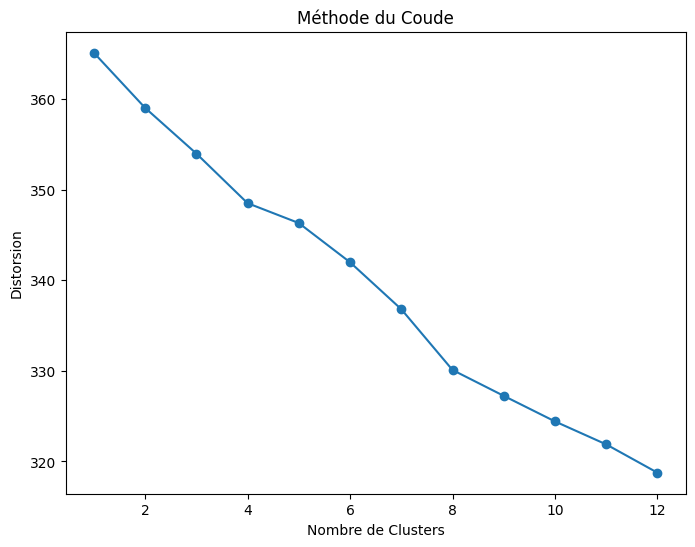

Nombre optimal de clusters : 8
Cluster 1 sauvegardé dans output/clusters/cluster_1.json
Cluster 6 sauvegardé dans output/clusters/cluster_6.json
Cluster 5 sauvegardé dans output/clusters/cluster_5.json
Cluster 2 sauvegardé dans output/clusters/cluster_2.json
Cluster 0 sauvegardé dans output/clusters/cluster_0.json
Cluster 4 sauvegardé dans output/clusters/cluster_4.json
Cluster 7 sauvegardé dans output/clusters/cluster_7.json
Cluster 3 sauvegardé dans output/clusters/cluster_3.json


In [34]:
num_clusters = find_optimal_clusters("content3.json", max_k=12)  
print(f'Nombre optimal de clusters : {num_clusters}')

clusters, similarity_matrix = cluster_documents("content3.json", num_clusters)

# Afficher et sauvegarder les contenus des clusters
save_clusters_individually(clusters, "content3.json")

In [35]:
clusters_dir = "output/clusters"
original_links_path = "links3.json"
output_dir = "cluster_links"

create_links_per_cluster(clusters_dir, original_links_path, output_dir)

Fichier de liens créé pour le cluster : cluster_links\cluster_0_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_1_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_2_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_3_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_4_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_5_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_6_links.json
Fichier de liens créé pour le cluster : cluster_links\cluster_7_links.json


JSON to GML

In [40]:
links = "links3.json"
output_file = "outputgml/graph.gml"
json_to_gml(links, output_file)

Fichier GML créé : outputgml/graph.gml


In [42]:
output_file1 = "outputgml/tokens_graph.gml"
output_file2 = "outputgml/clusters_graph.gml"
tokens_file = "output/cleaned_data.json"
clusters_file = "output/clusters.json"
json_to_gml(tokens_file, output_file1)
json_to_gml(clusters_file, output_file2)

Fichier GML créé : outputgml/tokens_graph.gml
Fichier GML créé : outputgml/clusters_graph.gml


In [43]:
output_file = "outputgml/similarity_graph.gml"
generate_similarity_graph(content, similarity_matrix, output_file)

Graphe de similarité créé : outputgml/similarity_graph.gml


In [ ]:
num_clusters = find_optimal_clusters("content3.json", max_k=10)
for i in range(0,num_clusters):
    json_to_gml(f"cluster_links/cluster_{i}_links.json", f"outputgml/cluster_{i}.gml")